In [1]:
from util import *
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.model_selection import cross_validate, LeaveOneGroupOut, cross_val_score
from sklearn.svm import LinearSVC, SVC
from sklearn.dummy import DummyClassifier
import os
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stat
from sklearn import svm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

/home/vm01/anaconda3/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
subject_id = '02'
fmri_image = list()
mask_image = list()
for run in range(1, 11):
    if run%2 == 0:
        task = 'rotate'
    else:
        task = 'straight'
    fmri_file = f"data/derivatives/sub-{subject_id}/func/sub-{subject_id}_task-{task}_run-{run}_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"
    fmri_image.append(fmri_file)


In [3]:
atlas = datasets.fetch_atlas_juelich("maxprob-thr25-2mm")

In [4]:
masks = {"premotor":"GM Premotor cortex BA6", 
         "motor": "GM Primary motor cortex BA4a",
         "v1": "GM Visual cortex V1 BA17",
         "sup_parietal": "GM Superior parietal lobule 7P",
         "inf_parietal": "GM Inferior parietal lobule PF",
         "somatosensory": "GM Primary somatosensory cortex BA1"
        }


In [342]:
scores = {}
distance = {}
for mask in masks.keys():
    run_scores = []
    
    for run in range(1, 11):
        run_no = str(run).zfill(2)
        beta_maps_dir = f'analyses_results/sub-{subject_id}/beta_maps/trial_level/run-{run_no}/'
        run_beta_maps = os.listdir(f'analyses_results/sub-{subject_id}/beta_maps/trial_level/run-{run_no}/')

        z_maps = {}

        for i in run_beta_maps:
            z_maps[i[5:-7]] = image.load_img(os.path.join(beta_maps_dir, i))

        #Sorted by first number
        all_images = image.concat_imgs((z_maps['153'], z_maps['207'], z_maps['45'], z_maps['99']))
        #mean_image = image.mean_img(all_images)
        #mean_centered = image.math_img("np.subtract(all_images, mean_image[:, :, :, None])", all_images = all_images, mean_image = mean_image)
        mean_centered = all_images

        for i, key in enumerate(np.sort(list(z_maps.keys()))):

            z_maps[key] = image.index_img(mean_centered, slice(i*10,i*10+10))

        mask_image = image.new_img_like(atlas.maps, image.get_data(atlas.maps) == np.where(np.array(atlas.labels) == masks[mask])[0][0])
        resampled_mask = image.resample_to_img(mask_image, mean_centered, interpolation='nearest')

        fmri_masked = masking.apply_mask(mean_centered, mask_img=resampled_mask)

        #y = np.repeat(np.sort(list(z_maps.keys())), 10)
        #X = fmri_masked
        
        if run == 1:
            X = np.zeros((400, fmri_masked.shape[1]))
            y = np.zeros((400))
            #X_train = np.zeros((200, fmri_masked.shape[1]))
            #y_train = np.zeros(200)
            #X_test = np.zeros((200, fmri_masked.shape[1]))
            #y_test = np.zeros(200)
        """
        if run%2 != 0:
            y_train[(int(run/2)-1)*40:(int(run/2)-1)*40+40] = np.repeat(np.sort(list(z_maps.keys())), 10)
            X_train[(int(run/2)-1)*40:(int(run/2)-1)*40+40] = fmri_masked
            
        else:
            y_test[(int(run/2)-1)*40:(int(run/2)-1)*40+40] = np.repeat(np.sort(list(z_maps.keys())), 10)
            X_test[(int(run/2)-1)*40:(int(run/2)-1)*40+40] = fmri_masked
        """
        X[(run-1)*40:(run-1)*40 + 40] = fmri_masked
        y[(run-1)*40:(run-1)*40 + 40] = np.repeat(np.sort(list(z_maps.keys())), 10)
    
    pc = PCA(n_components=20)
    reduced_x = pc.fit_transform(X)
    
    X_train = np.vstack(np.vsplit(reduced_x, 10)[0::2])
    X_test = np.vstack(np.vsplit(reduced_x, 10)[1::2])

    y_train = np.ravel(np.split(y, 10)[0::2])
    y_test = np.ravel(np.split(y, 10)[1::2])

    classifier = svm.SVC(kernel="rbf", C = 1.5)
    classifier.fit(X_train, y_train)
    #run_scores.append(classifier.score(X_test, y_test))

    #scores[mask] = run_scores

    
    scores[mask] = classifier.score(X_test, y_test)
    

    print("Mask Done: ", mask)

Mask Done:  premotor
Mask Done:  motor
Mask Done:  v1
Mask Done:  sup_parietal
Mask Done:  inf_parietal
Mask Done:  somatosensory


In [343]:
scores

{'premotor': 0.31,
 'motor': 0.27,
 'v1': 0.445,
 'sup_parietal': 0.29,
 'inf_parietal': 0.28,
 'somatosensory': 0.26}

In [336]:
scores

{'premotor': 0.26,
 'motor': 0.275,
 'v1': 0.42,
 'sup_parietal': 0.285,
 'inf_parietal': 0.305,
 'somatosensory': 0.295}

(400, 20)

In [329]:
df = pd.DataFrame(scores)

ValueError: If using all scalar values, you must pass an index

In [254]:
df['run_pairs'] = range(5)

In [255]:
df_melt = df.melt(id_vars="run_pairs", var_name='ROI', value_name='scores')

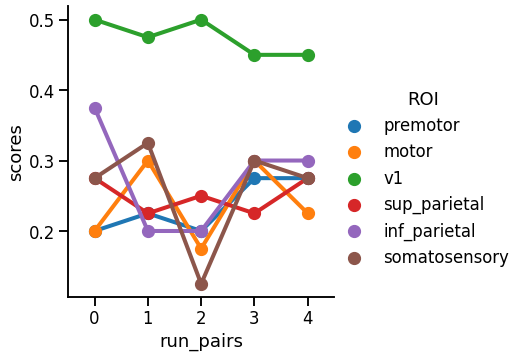

In [346]:
sns.set_context('talk')
sns.catplot(x = 'run_pairs', y = 'scores', hue = 'ROI', data = df_melt, kind = 'point')